In [3]:
import sys
sys.path.append(r"C:\Users\AviGoyal\Documents\LightingStudio\src")

import numpy as np
from pathlib import Path

from LightingStudio.analysis.utils import read_exr

In [4]:
exr_path = Path(r"C:\Users\AviGoyal\Documents\LightingStudio") / "tmp" / "source" / "1k" / "Abandoned Bakery.exr"

numpy_exr = read_exr(exr_path)

In [6]:
r, g, b = numpy_exr[0][0]
print(f"r: {r}, g: {g}, b: {b}")

luminance = 0.2125 * r + 0.7154 * g + 0.0721 * b
print(f"luminance: {luminance}")








r: 0.0458984375, g: 0.039794921875, b: 0.029052734375
luminance: 0.04031740501523018


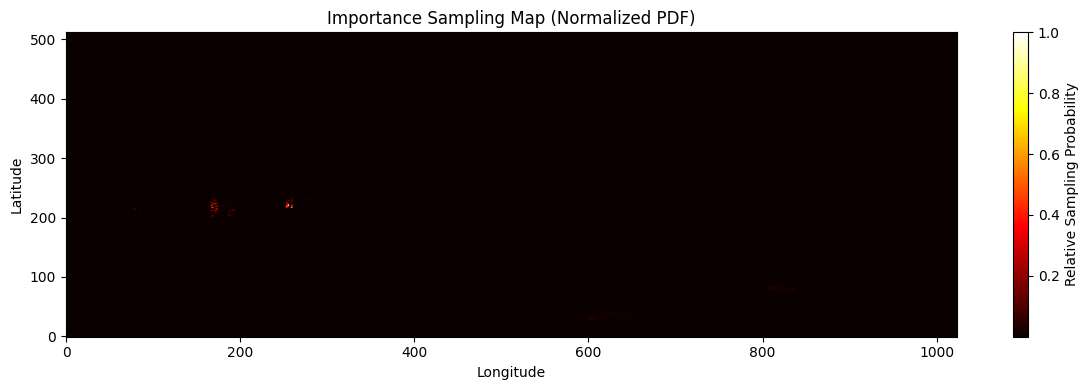

In [7]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Load HDR image ===
hdr_image_path = str(Path(r"C:\Users\AviGoyal\Documents\LightingStudio") / "tmp" / "source" / "1k" / "Abandoned Bakery.exr")
hdr = cv2.imread(hdr_image_path, flags=cv2.IMREAD_UNCHANGED)

if hdr is None:
    raise FileNotFoundError("Could not load HDR image. Check the file path and format.")

# === Get image dimensions ===
height, width, _ = hdr.shape

# === Convert RGB to luminance ===
# Using Rec. 709 luminance coefficients
luminance = 0.2126 * hdr[:, :, 2] + 0.7152 * hdr[:, :, 1] + 0.0722 * hdr[:, :, 0]

# === Solid angle correction (sin(theta)) ===
theta = np.pi * (np.arange(height) + 0.5) / height  # center of each pixel row
sin_theta = np.sin(theta).reshape(-1, 1)
weighted_luminance = luminance * sin_theta  # shape: (H, W)

# === Normalize to get PDF ===
total_luminance = np.sum(weighted_luminance)
pdf = weighted_luminance / total_luminance  # shape: (H, W)

# === Build Marginal (Y) and Conditional (X|Y) CDFs ===
marginal_pdf = np.sum(pdf, axis=1)
marginal_cdf = np.cumsum(marginal_pdf)
marginal_cdf /= marginal_cdf[-1]

conditional_cdf = np.cumsum(pdf, axis=1)
conditional_cdf /= conditional_cdf[:, -1][:, np.newaxis]  # normalize each row

# === Visualization ===
importance_map = pdf / np.max(pdf)

plt.figure(figsize=(12, 4))
plt.imshow(importance_map, cmap='hot', origin='lower', aspect='auto')
plt.title("Importance Sampling Map (Normalized PDF)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Relative Sampling Probability')
plt.tight_layout()
plt.show()